Loaded SHAP values shape: (3, 224, 224, 10)


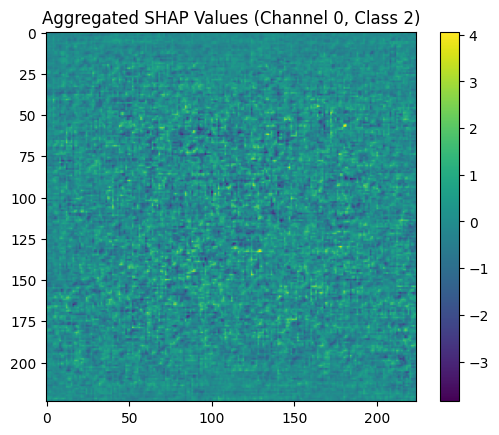

In [2]:
import numpy as np
import os 
# Path to the saved .npy file
file_path = '/home/j597s263/scratch/j597s263/Datasets/Shap/Shap_Imagenette.npy'

# Load the SHAP values
shap_values = np.load(file_path)
channel=0
class_idx=2
# Print the shape of the loaded SHAP values
print(f"Loaded SHAP values shape: {shap_values.shape}")

import matplotlib.pyplot as plt
plt.imshow(shap_values[channel, :, :, class_idx], cmap="viridis")
plt.title(f"Aggregated SHAP Values (Channel {channel}, Class {class_idx})")
plt.colorbar()
plt.show()

In [2]:
aggregated_shap_image = np.sum(shap_values, axis=(0))  # Shape: (224, 224)
aggregated_shap_image.shape

(224, 224, 10)

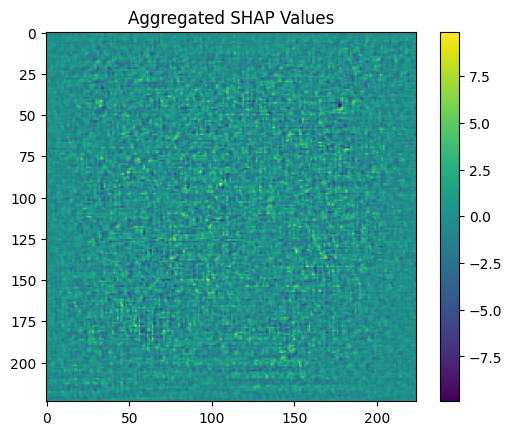

In [3]:
plt.imshow(aggregated_shap_image[:, :, 4], cmap="viridis")
plt.title("Aggregated SHAP Values")
plt.colorbar()
plt.show()

In [4]:
# Aggregate SHAP values across channels for class 2
class_idx = 2
aggregated_class_2 = np.sum(shap_values[:, :, :, class_idx], axis=0)  # Shape: (224, 224)

# Flatten the array and find the indices of the top 22 values
flattened = aggregated_class_2.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_class_2.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
for coord in top_22_coords:
    pixel_value = aggregated_class_2[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Pixel (np.int64(130), np.int64(178)): SHAP Value 9.0632
Pixel (np.int64(58), np.int64(106)): SHAP Value 8.5277
Pixel (np.int64(133), np.int64(127)): SHAP Value 7.9947
Pixel (np.int64(98), np.int64(102)): SHAP Value 7.7140
Pixel (np.int64(94), np.int64(111)): SHAP Value 7.6071
Pixel (np.int64(60), np.int64(89)): SHAP Value 7.6006
Pixel (np.int64(145), np.int64(119)): SHAP Value 7.5982
Pixel (np.int64(133), np.int64(129)): SHAP Value 7.5374
Pixel (np.int64(61), np.int64(89)): SHAP Value 7.3279
Pixel (np.int64(98), np.int64(114)): SHAP Value 7.1619
Pixel (np.int64(98), np.int64(101)): SHAP Value 7.1122
Pixel (np.int64(99), np.int64(102)): SHAP Value 6.9877
Pixel (np.int64(179), np.int64(52)): SHAP Value 6.8313
Pixel (np.int64(62), np.int64(142)): SHAP Value 6.8293
Pixel (np.int64(51), np.int64(67)): SHAP Value 6.7536
Pixel (np.int64(72), np.int64(81)): SHAP Value 6.7211
Pixel (np.int64(99), np.int64(101)): SHAP Value 6.7171
Pixel (np.int64(38), np.int64(71)): SHAP Value 6.6416
Pixel (np.i

In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ConvMixer input size
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.Imagenette(root='/home/j597s263/scratch/j597s263/Datasets/imagenette', download=False, transform=transform)

# Shuffle indices with a fixed random seed for reproducibility
random.seed(42)  # Use any fixed seed for consistency
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split shuffled indices into training and testing
train_indices = indices[:7568]
test_indices = indices[7568:8522]
attack_indices = indices[8522:]

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
attack_data = Subset(dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # No shuffle for test set
attack_loader = DataLoader(attack_data, batch_size=5, shuffle=True)

# Print dataset sizes
print(f"Attack samples: {len(attack_data)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Attack samples: 947
Training samples: 7568
Test samples: 954


In [5]:
from collections import Counter

attack_labels = [dataset[i][1] for i in attack_indices]

label_counts = Counter(attack_labels)

for label in range(0, 10): 
    print(f"Label {label}: {label_counts.get(label, 0)} samples")


Label 0: 90 samples
Label 1: 105 samples
Label 2: 89 samples
Label 3: 81 samples
Label 4: 117 samples
Label 5: 101 samples
Label 6: 77 samples
Label 7: 101 samples
Label 8: 94 samples
Label 9: 92 samples


In [4]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [5]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Conv_Imagenette.mod', weights_only=False, map_location="cuda:0")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


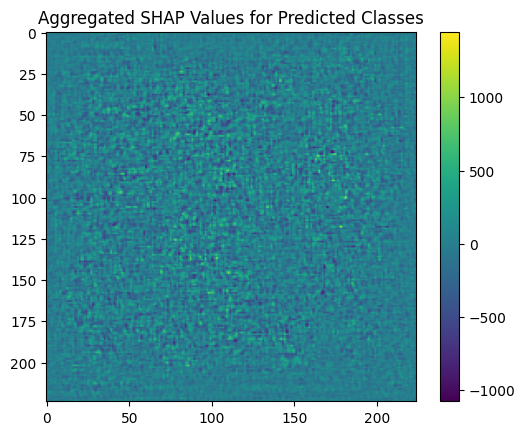

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load SHAP values
file_path = '/home/j597s263/scratch/j597s263/Datasets/Shap/Shap_Imagenette.npy'
shap_values = np.load(file_path)  # Shape: (3, 224, 224, 10)


device = 'cuda'
model.eval()

# Initialize aggregated SHAP array
aggregated_shap_image = np.zeros((224, 224))

# Iterate through the attack_loader to compute predicted classes
for batch_images, _ in attack_loader:
    batch_images = batch_images.to(device)

    # Get model predictions
    outputs = model(batch_images)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (batch_size,)

    # Compute SHAP values for each image
    for i, predicted_class in enumerate(predicted_classes):
        # Aggregate SHAP values for the predicted class (sum over channels)
        class_shap_values = np.sum(shap_values[:, :, :, predicted_class], axis=0)  # Shape: (224, 224)
        aggregated_shap_image += class_shap_values

# Visualize the aggregated SHAP image
plt.imshow(aggregated_shap_image, cmap="viridis")
plt.title("Aggregated SHAP Values for Predicted Classes")
plt.colorbar()
plt.show()


In [9]:
# Flatten the array and find the indices of the top 22 values
flattened = aggregated_shap_image.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_shap_image.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
print("Top 22 Pixels and Their SHAP Values:")
for coord in top_22_coords:
    pixel_value = aggregated_shap_image[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Top 22 Pixels and Their SHAP Values:
Pixel (np.int64(118), np.int64(178)): SHAP Value 1448.4429
Pixel (np.int64(100), np.int64(181)): SHAP Value 1197.7242
Pixel (np.int64(75), np.int64(164)): SHAP Value 1127.1482
Pixel (np.int64(137), np.int64(103)): SHAP Value 1103.3049
Pixel (np.int64(126), np.int64(78)): SHAP Value 1068.4652
Pixel (np.int64(74), np.int64(175)): SHAP Value 1063.3937
Pixel (np.int64(146), np.int64(110)): SHAP Value 1026.6222
Pixel (np.int64(86), np.int64(46)): SHAP Value 1012.8565
Pixel (np.int64(158), np.int64(98)): SHAP Value 994.4789
Pixel (np.int64(90), np.int64(173)): SHAP Value 968.8513
Pixel (np.int64(106), np.int64(134)): SHAP Value 966.8707
Pixel (np.int64(84), np.int64(165)): SHAP Value 939.5804
Pixel (np.int64(97), np.int64(45)): SHAP Value 921.4845
Pixel (np.int64(74), np.int64(174)): SHAP Value 906.9280
Pixel (np.int64(77), np.int64(163)): SHAP Value 888.4969
Pixel (np.int64(84), np.int64(110)): SHAP Value 879.7816
Pixel (np.int64(90), np.int64(174)): SHA

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/Imagenette"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (from your output)
top_22_coords = [
    (118, 178), (100, 181), (75, 164), (137, 103), (126, 78),
    (74, 175), (146, 110), (86, 46), (158, 98), (90, 173),
    (106, 134), (84, 165), (97, 45), (74, 174), (77, 163),
    (84, 110), (90, 174), (137, 87), (86, 106), (186, 142),
    (74, 173), (138, 87)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (0 value for all channels)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")


In [4]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/Imagenette"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (from your output)
top_22_coords = [
    (118, 178), (100, 181), (75, 164), (137, 103), (126, 78),
    (74, 175), (146, 110), (86, 46), (158, 98), (90, 173),
    (106, 134), (84, 165), (97, 45), (74, 174), (77, 163),
    (84, 110), (90, 174), (137, 87), (86, 106), (186, 142),
    (74, 173), (138, 87)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (all three channels set to 0)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")


Processed batch 1/190
Processed batch 2/190
Processed batch 3/190
Processed batch 4/190
Processed batch 5/190
Processed batch 6/190
Processed batch 7/190
Processed batch 8/190
Processed batch 9/190
Processed batch 10/190
Processed batch 11/190
Processed batch 12/190
Processed batch 13/190
Processed batch 14/190
Processed batch 15/190
Processed batch 16/190
Processed batch 17/190
Processed batch 18/190
Processed batch 19/190
Processed batch 20/190
Processed batch 21/190
Processed batch 22/190
Processed batch 23/190
Processed batch 24/190
Processed batch 25/190
Processed batch 26/190
Processed batch 27/190
Processed batch 28/190
Processed batch 29/190
Processed batch 30/190
Processed batch 31/190
Processed batch 32/190
Processed batch 33/190
Processed batch 34/190
Processed batch 35/190
Processed batch 36/190
Processed batch 37/190
Processed batch 38/190
Processed batch 39/190
Processed batch 40/190
Processed batch 41/190
Processed batch 42/190
Processed batch 43/190
Processed batch 44/1